# Natural language engineering 2: Assignment

## Classification of Twitter posts regarding the Ukrainian War by emotion

A project by **Johannes Wittmann** and **Quirin Wittmann**.

In [ ]:
from pprint import pprint

### Data crawling

### Data preprocessing

### Model finetuning

Neccesary dependencys for finetuning with Huggingface.

In [ ]:
!pip install datasets transformers
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 8.2 MB/s 
     |████████████████████████████████| 4.4 MB 24.2 MB/s 
     |████████████████████████████████| 101 kB 11.9 MB/s 
     |████████████████████████████████| 1.1 MB 57.1 MB/s 
     |████████████████████████████████| 140 kB 69.6 MB/s 
     |████████████████████████████████| 212 kB 68.6 MB/s 
     |████████████████████████████████| 596 kB 56.9 MB/s 
     |████████████████████████████████| 127 kB 67.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.3 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 64.5 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing

Finetuning imports:


In [ ]:
from datasets import load_dataset
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

Load Twitter dataset for emotions: <br>
[https://huggingface.co/datasets/tweet_eval/viewer/emotion/train](https://huggingface.co/datasets/tweet_eval/viewer/emotion/train)

In [ ]:
emotion_dataset = load_dataset("tweet_eval", "emotion")
print(emotion_dataset["train"][0])

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry", 'label': 2}


Embedd tweets:

In [ ]:
#checkpoint = "bhadresh-savani/distilbert-base-uncased-emotion" # F1 0,768
#checkpoint = "bert-base-uncased"
#checkpoint = "bert-large-uncased" # F1 0,78
#checkpoint = "roberta-large" # F1 0,82 
#checkpoint = "cardiffnlp/twitter-roberta-base-sentiment" # F1 0,815
checkpoint = "cardiffnlp/twitter-roberta-base-sentiment-latest" # F1 0,8178 | b=64: F1 0,823
#!pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Tokenisation function defining:

In [ ]:
def tokenize_example(example):
  return tokenizer(example["text"], truncation=True)

Tokenize dataset with function:

In [ ]:
emotion_dataset_tokenized = emotion_dataset.map(tokenize_example, batched=True)

Parameter 'function'=<function tokenize_example at 0x7fcc60ad4290> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/4 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Defining the dataset padder:

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Classification Head:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4, ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

Define the evaluation function.
Huggingface reccomends accuracy, recall, precision and F1 for text classification. <br>
[Metrics for Text Classification](https://huggingface.co/tasks/text-classification)

In [ ]:
def evaluate(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="macro")
  accuracy = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average="macro")
  recall = recall_score(labels, preds, average="macro")
  return {"precision": precision, "recall": recall, "accuracy": accuracy, "f1": f1}

Defining the trainingparameters:

In [ ]:
batch_size = 64 # Für schlaubox.de mindestens 128, 256 kann man auch probieren
logging_steps = len(emotion_dataset_tokenized["train"])
model_name = f"{checkpoint}-finetuned-tweet_emotion"
training_args = TrainingArguments(output_dir = model_name, 
                                  num_train_epochs = 9, 
                                  learning_rate = 2e-5, 
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  evaluation_strategy="epoch",
                                  disable_tqdm = False, 
                                  logging_steps = logging_steps, 
                                  log_level="error")

Creating the trainer:

In [ ]:
print(len(emotion_dataset_tokenized["train"]))
print(len(emotion_dataset_tokenized["test"]))
print(len(emotion_dataset_tokenized["validation"]))
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = evaluate,
    train_dataset=emotion_dataset_tokenized["train"], 
    eval_dataset=emotion_dataset_tokenized["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

3257
1421
374


Training:

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Precision,Recall,Accuracy,F1
1,No log,0.492899,0.809850,0.787188,0.834624,0.796417
2,No log,0.470050,0.830302,0.787295,0.840957,0.804577
3,No log,0.484288,0.814977,0.825946,0.847291,0.819675
4,No log,0.512679,0.815163,0.827298,0.847291,0.820395
5,No log,0.592068,0.812973,0.807614,0.838846,0.807879
6,No log,0.580279,0.809317,0.816321,0.840957,0.812382
7,No log,0.595128,0.813706,0.827782,0.846587,0.819432
8,No log,0.614709,0.812864,0.831690,0.847291,0.821203
9,No log,0.604920,0.822719,0.831934,0.853624,0.826978


TrainOutput(global_step=459, training_loss=0.2843374613842933, metrics={'train_runtime': 286.4385, 'train_samples_per_second': 102.336, 'train_steps_per_second': 1.602, 'total_flos': 774926848285512.0, 'train_loss': 0.2843374613842933, 'epoch': 9.0})

In [ ]:
trainer.save_model("./outputmodel")

### Classification

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification

In [ ]:
import os
os.listdir("/content/outputmodel/")

['vocab.json',
 'tokenizer_config.json',
 'pytorch_model.bin',
 'config.json',
 'tokenizer.json',
 'merges.txt',
 'special_tokens_map.json',
 'training_args.bin']

In [ ]:
checkpoint = "/content/outputmodel/"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)
emotion_pipe = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer)

print(model.config.id2label)

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3'}


Test der Pipeline:

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
    "I love this so much",
    "I am looking forward to it",
    "We must stay optimistic",
    "Why did this happen?",
    "Why did you do this to me?",
    "Why didn't you clean this mess?",
    "I am sorry",
    "I am so excited",
]
#0: anger
#1: joy
#2: optimism
#3: sadness
pprint(emotion_pipe(raw_inputs))

[{'label': 'LABEL_1', 'score': 0.9796430468559265},
 {'label': 'LABEL_0', 'score': 0.9961112141609192},
 {'label': 'LABEL_1', 'score': 0.9942916631698608},
 {'label': 'LABEL_1', 'score': 0.9926517605781555},
 {'label': 'LABEL_2', 'score': 0.9908236265182495},
 {'label': 'LABEL_0', 'score': 0.9924883842468262},
 {'label': 'LABEL_0', 'score': 0.9957154393196106},
 {'label': 'LABEL_0', 'score': 0.9956786036491394},
 {'label': 'LABEL_3', 'score': 0.9939582347869873},
 {'label': 'LABEL_1', 'score': 0.9934327602386475}]


In [ ]:
predictions = emotion_pipe(raw_inputs)

In [ ]:
predicted_labels = []
for prediction in predictions:
  predicted_labels.append(prediction['label'].lower())


pprint(predicted_labels)

['label_1',
 'label_0',
 'label_1',
 'label_1',
 'label_2',
 'label_0',
 'label_0',
 'label_0',
 'label_3',
 'label_1']


### Data analysis and postprocessing

In [ ]:
import pandas as pd
import random
import numpy as np
import datetime
from dateutil.parser import parse

dates = ["2022-02-24", "2022-02-26", "2022-03-05", "2022-04-07", "2022-05-15", "2022-06-06", "2022-06-28"]
datesFalse = ["2022-02-24", "2022-02-25", "2022-02-28", "2022-02-26", "2022-03-05", "2022-04-07", "2022-04-17", "2022-01-07", "2022-04-08", "2022-05-15", "2022-06-06", "2022-06-28"]
datesFalse = [parse(x) for x in datesFalse]
countries = ["UKR", "RUS", "GBR", "GER", "ITA", "CHE", "CHN", "FRA", "USA", "BLR", "POL"]
labelNames = ["Joy", "Anger", "Sadness", "Optimism"]

def computeEvent(timestamp):
  return random.choice(datesFalse)

def computeCountry(value):
  return random.choice(countries)

# Load tweets into session storage
try:
  tweets_df = pd.read_csv("./tweets.csv")
except:
  print("Please load tweets.csv into colab session storage. (Dateien -> In Sitzungsspeicher laden)")

print(tweets_df)

rows = len(tweets_df.index)

classification_results_list = []

for i in range(rows):
  id = tweets_df.iloc[i]["id"]
  text = tweets_df.iloc[i]["text"]
  event = computeEvent(tweets_df.iloc[i]["created_at"])
  country = computeCountry(tweets_df.iloc[i]["lang"])
  label = emotion_pipe(text)
  classification_results_list.append({"id": id,"label": label, "event": event, "country": country})
  

pprint(classification_results_list)
  
df = pd.DataFrame(classification_results_list)

                      id                 created_at  \
0    1501347029338972161  2022-03-09 00:00:00+00:00   
1    1501347030647508997  2022-03-09 00:00:00+00:00   
2    1501347030333018118  2022-03-09 00:00:00+00:00   
3    1501347030387417092  2022-03-09 00:00:00+00:00   
4    1501347029641015296  2022-03-09 00:00:00+00:00   
..                   ...                        ...   
831  1531787620019146753  2022-06-01 00:00:02+00:00   
832  1531787625434054657  2022-06-01 00:00:03+00:00   
833  1531787616898654209  2022-06-01 00:00:01+00:00   
834  1531787613568389125  2022-06-01 00:00:00+00:00   
835  1531787621768249345  2022-06-01 00:00:02+00:00   

                                                  text lang  \
0    RT @WorldVision: As we celebrate #Internationa...   en   
1    Russia Ukraine War: Russia bows to pressure? N...   en   
2    Discover - Can you feel it by Modis Chrisha - ...   en   
3    RT @sanusi90064: EUROPEAN LIES \nThis guy mess...   en   
4    RT @cbctom: A Germa

In [ ]:

# Analyzes a countries emotion percentages for a dataframe
def analyzeCountry(country, df, date_string):
  df_country = df.loc[df['country'] == country]
  label_counts = df_country.label.value_counts()
  df_label_counts = label_counts.to_frame()
  sum = df_label_counts["label"].sum()
  anger_perc = 0
  joy_perc = 0
  sadness_perc = 0
  optimism_perc = 0
  if 'Anger' in df_label_counts.index:
    anger = df_label_counts.loc["Anger"]["label"]
    anger_perc = (anger / sum) *100
  if 'Joy' in df_label_counts.index:
    joy = df_label_counts.loc["Joy"]["label"]
    joy_perc = (joy / sum) *100
  if 'Sadness' in df_label_counts.index:
    sadness = df_label_counts.loc["Sadness"]["label"]
    sadness_perc = (sadness / sum) *100
  if 'Optimism' in df_label_counts.index:
    optimism = df_label_counts.loc["Optimism"]["label"]
    optimism_perc = (optimism / sum) *100

  print("Labels for country " + country +" (After Event: "+ date_string +"):\n"+ label_counts.to_string() +"\n\n"+
        "Percentage of anger: "+ str(anger_perc)+ "% \n" +
        "Percentage of joy: "+ str(joy_perc)+ "% \n" +
        "Percentage of sadness: "+ str(sadness_perc)+ "% \n" +
        "Percentage of optimism: "+ str(optimism_perc) +"% \n" )
  
def getDataframeAfterEvent(df, event):
    print("Test")

for country in countries:
  # Analyze with general dataframe
  analyzeCountry(country, df, "general")
  # Analyze after certain war event






TypeError: ignored

Labels for country UKR (After Event: general):
[{'label': 'LABEL_3', 'score': 0.9079434275627136}]     1
[{'label': 'LABEL_1', 'score': 0.4366382360458374}]     1
[{'label': 'LABEL_3', 'score': 0.45790114998817444}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: ignored

Labels for country RUS (After Event: general):
[{'label': 'LABEL_2', 'score': 0.9781488180160522}]    1
[{'label': 'LABEL_0', 'score': 0.9731220602989197}]    1
[{'label': 'LABEL_2', 'score': 0.8681337237358093}]    1
[{'label': 'LABEL_0', 'score': 0.8598982691764832}]    1
[{'label': 'LABEL_3', 'score': 0.4407956302165985}]    1
[{'label': 'LABEL_0', 'score': 0.9698744416236877}]    1
[{'label': 'LABEL_3', 'score': 0.8207921385765076}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 

Labels for country GBR (After Event: general):
Series([], )

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: ignored

Labels for country GER (After Event: general):
[{'label': 'LABEL_2', 'score': 0.9714725613594055}]    1
[{'label': 'LABEL_1', 'score': 0.9937576055526733}]    1
[{'label': 'LABEL_2', 'score': 0.9432049989700317}]    1
[{'label': 'LABEL_2', 'score': 0.5060459971427917}]    1
[{'label': 'LABEL_3', 'score': 0.6220278143882751}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: ignored

Labels for country ITA (After Event: general):
[{'label': 'LABEL_0', 'score': 0.9674734473228455}]    1
[{'label': 'LABEL_0', 'score': 0.7632380127906799}]    1
[{'label': 'LABEL_0', 'score': 0.9698744416236877}]    1
[{'label': 'LABEL_0', 'score': 0.5302687287330627}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: ignored

Labels for country CHE (After Event: general):
[{'label': 'LABEL_0', 'score': 0.6448777318000793}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: ignored

Labels for country CHN (After Event: general):
[{'label': 'LABEL_1', 'score': 0.7872549295425415}]    1
[{'label': 'LABEL_3', 'score': 0.7453845143318176}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: ignored

Labels for country FRA (After Event: general):
[{'label': 'LABEL_3', 'score': 0.9410732984542847}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: ignored

Labels for country USA (After Event: general):
[{'label': 'LABEL_0', 'score': 0.9752369523048401}]    1
[{'label': 'LABEL_3', 'score': 0.8831666111946106}]    1
[{'label': 'LABEL_3', 'score': 0.7121788263320923}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


Labels for country BLR (After Event: general):
[{'label': 'LABEL_3', 'score': 0.9079434275627136}]    1
[{'label': 'LABEL_0', 'score': 0.5242370963096619}]    1
[{'label': 'LABEL_0', 'score': 0.5659675002098083}]    1
[{'label': 'LABEL_1', 'score': 0.5564427971839905}]    1
[{'label': 'LABEL_3', 'score': 0.4691699147224426}]    1
[{'label': 'LABEL_2', 'score': 0.6502411961555481}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



TypeError: ignored

Labels for country POL (After Event: general):
[{'label': 'LABEL_0', 'score': 0.6379976868629456}]    1
[{'label': 'LABEL_3', 'score': 0.9808838367462158}]    1

Percentage of anger: 0% 
Percentage of joy: 0% 
Percentage of sadness: 0% 
Percentage of optimism: 0% 



Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# General country emotion overview
with sns.axes_style('white'):
    g = sns.catplot(x="country", data=df, aspect=2,
                       kind="count", hue='label', order=countries)

# General event emotion overview
with sns.axes_style('white'):
    g = sns.catplot(x="event", data=df, aspect=2,
                       kind="count", hue='label', order=dates)
    
grid = sns.FacetGrid(df, row="country", col="event", margin_titles=True, sharex=False, col_order=dates)
grid.map_dataframe(sns.histplot, "label")

      

TypeError: ignored

            Joy  Anger  Sadness  Optimism
2022-01-07  229    202      204       202
2022-05-15  227    183      200       192
2022-02-24  223    208      211       198
2022-04-17  218    208      195       214
2022-02-28  216    234      219       238
2022-02-25  213    225      216       212
2022-02-26  209    202      202       200
2022-04-08  199    178      202       216
2022-06-28  198    199      218       193
2022-03-05  189    175      228       218
2022-04-07  188    200      215       216
2022-06-06  184    215      201       211
2022-01-07    229
2022-05-15    227
2022-02-24    223
2022-04-17    218
2022-02-28    216
2022-02-25    213
2022-02-26    209
2022-04-08    199
2022-06-28    198
2022-03-05    189
2022-04-07    188
2022-06-06    184
Name: Joy, dtype: int64
2022-01-07    202
2022-05-15    183
2022-02-24    208
2022-04-17    208
2022-02-28    234
2022-02-25    225
2022-02-26    202
2022-04-08    178
2022-06-28    199
2022-03-05    175
2022-04-07    200
2022-06-06    21

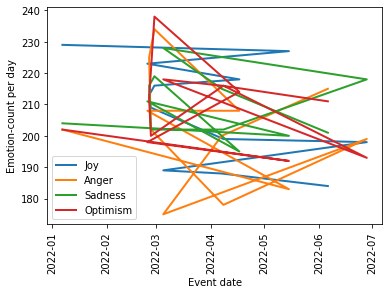

In [ ]:
labelEmotionCounts = {}
for label in labelNames:
  df_label = df.loc[df["label"] == label]
  #pprint(df_label)
  emotion_counts = df_label.event.value_counts()
  labelEmotionCounts[label] = emotion_counts.to_dict()
emoDf = pd.DataFrame(labelEmotionCounts)
emoDf.sort_index()
#TODO: sort by index
pprint(emoDf)
fig, ax = plt.subplots()
for label in labelEmotionCounts.keys():
  emotionLabel = emoDf[label]
  pprint(emotionLabel)
  ax.plot(emotionLabel.index, emotionLabel, linewidth=2.0, label = label)
ax.legend()
plt.xticks(rotation=90)
plt.xlabel("Event date")
plt.ylabel("Emotion-count per day")
plt.show()